## Part II - Implementation

Acknowledgement: using starter code from Ankit Vashisht

Link: https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Task I - Inspection

- In DBI, dogs in images of relatively plain and clear backgrounds and color of dogs are in great contrast with the background color. It is easy to separate the dogs from the background.
- In SDD, the images are overall of lower resolution than DBI. The backgrounds are much messier and dogs are surrounded with other objects. We can see objects like human beings, decorations, food, blankets, flowers, other animals etc., and some images contain captions and watermarks. Also, many SDD images have background color that are similar to dog colors. It is harder to separatethe dogs from backgrounds.

### Task II - simple CNN Training on the DBI

##### Create custom dataset

In [2]:
# load DBI dataset to PyTorch Dataset Format.
dataset = ImageFolder('/content/drive/MyDrive/CSC420/datasets/DBI_subset')
print(f'{len(dataset)} images')

# collect class names
breeds = []
for n in dataset.classes:
    breeds.append(n)
print(breeds)

# set seed
random_seed = 42
torch.manual_seed(random_seed)

# split dataset into train, val, test
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train_size, val_size, test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

646 images
['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriver', 'pug', 'siberian_husky']


(408, 45, 193)

In [3]:
# Create custom dataset class
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [4]:
# transforms
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #         [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #         [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                 [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
}

In [5]:
# set up datasets
train_dataset = DogBreedDataset(train_ds, image_transforms['train'])
val_dataset = DogBreedDataset(val_ds, image_transforms['val'])
test_dataset = DogBreedDataset(test_ds, image_transforms['test'])

0


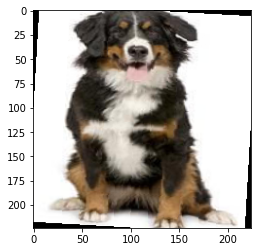

In [6]:
# extract a sample image from dataset
img, label = train_dataset[10]
print(label)
plt.imshow(img.permute(1,2,0))

2


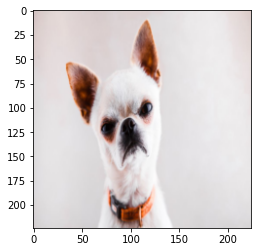

In [7]:
# extract a sample image from dataset
img, label = val_dataset[10]
print(label)
plt.imshow(img.permute(1,2,0))

In [8]:
# Create DataLoaders
batch_size = 64

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)


##### Network Architecture

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'train_acc':acc.detach(), 'train_loss':loss}
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["train_acc"], result["val_acc"]))
        

##### CNN Model

In [11]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self, dropout=True):
        super().__init__()
        self.dropout = dropout
        layers = [
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 16 * 224 * 224
            nn.BatchNorm2d(16),
            nn.ReLU(),          
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),  #  16 * 224 * 224  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                # 16 * 112 * 112
            nn.Conv2d(16, 8, 3, stride=1, padding=1),      # 8 * 112 * 112 
            nn.BatchNorm2d(8),
            nn.ReLU(), 
            nn.Conv2d(8, 8, 3, stride=1, padding=1),     # 8 * 112 * 112 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8 * 56 * 56 
        ]

        if not self.dropout:
            layers.extend([
                nn.Flatten(),
                nn.Linear(8*56*56, 32),
                nn.ReLU(),
                nn.LogSoftmax(dim = 1)
            ])
        else:
            layers.extend([
                nn.Dropout(0.5),  
                nn.Flatten(),
                nn.Linear(8*56*56, 32),
                nn.ReLU(),
                nn.Dropout(0.5),  
                nn.LogSoftmax(dim = 1)
            ])
        self.network = nn.Sequential(*layers)
    
    def forward(self, xb):
        return self.network(xb)

In [12]:
CNNmodel = DogBreedClassificationCNN(dropout = True)
CNNmodel2 = DogBreedClassificationCNN(dropout = False) #opt out for dropout
CNNmodel, CNNmodel2

(DogBreedClassificationCNN(
   (network): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU()
     (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (10): ReLU()
     (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (12): Dropout(p=0.5, inplace=False)
     (13): Flatten(start_dim=1, end_dim=-1)
     (14): Linear(in_features=25088, out_features=32, bias=True)
     (15): ReLU()
     (16): Dropout(p=0.5, inplace=False)
     (17): LogSoft

##### Moving Data to GPU

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [14]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [15]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# moving model to gpu
# in my case, only cpu is available
to_device(CNNmodel, device)
to_device(CNNmodel2, device)

cuda


DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=25088, out_features=32, bias=True)
    (14): ReLU()
    (15): LogSoftmax(dim=1)
  )
)

##### Training

In [16]:
from tqdm.notebook import tqdm

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        train_acc = []
        lrs = []
        for batch in tqdm(train_loader):
            result = model.training_step(batch)

            train_acc.append(result['train_acc'])
            train_losses.append(result['train_loss'].detach())

            # calculates gradients
            result['train_loss'].backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [18]:
evaluate(CNNmodel, val_dl)   

{'val_loss': 3.464902639389038, 'val_acc': 0.0}

In [19]:
evaluate(CNNmodel2, test_dl)

{'val_loss': 3.4671411514282227, 'val_acc': 0.0}

In [20]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [21]:
history = fit_one_cycle(num_epochs, max_lr, CNNmodel, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.6030, val_loss: 3.4015, train_acc: 0.0885, val_acc: 0.1395


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 3.3273, val_loss: 3.3611, train_acc: 0.1786, val_acc: 0.1591


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 3.1399, val_loss: 3.1871, train_acc: 0.2113, val_acc: 0.1978


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 3.2263, val_loss: 3.2705, train_acc: 0.1667, val_acc: 0.2289


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 3.2509, val_loss: 3.2146, train_acc: 0.1875, val_acc: 0.2248


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 3.1164, val_loss: 3.1601, train_acc: 0.2411, val_acc: 0.2560


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 3.0685, val_loss: 2.8327, train_acc: 0.2143, val_acc: 0.3413


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 2.9276, val_loss: 3.0153, train_acc: 0.2664, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 2.9048, val_loss: 2.9750, train_acc: 0.2760, val_acc: 0.2443


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 2.9575, val_loss: 2.9298, train_acc: 0.2582, val_acc: 0.2910


In [22]:
history2 = fit_one_cycle(num_epochs, max_lr, CNNmodel2, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.3298, val_loss: 3.3539, train_acc: 0.1205, val_acc: 0.1591


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 2.7751, val_loss: 3.1544, train_acc: 0.1949, val_acc: 0.1822


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 2.4913, val_loss: 2.7020, train_acc: 0.1860, val_acc: 0.2439


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 2.3350, val_loss: 2.3994, train_acc: 0.2857, val_acc: 0.2519


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.9992, val_loss: 2.1766, train_acc: 0.3385, val_acc: 0.1746


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.8086, val_loss: 1.9609, train_acc: 0.3162, val_acc: 0.2323


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.7431, val_loss: 1.7305, train_acc: 0.3281, val_acc: 0.3447


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.6050, val_loss: 1.7486, train_acc: 0.3698, val_acc: 0.3486


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.5461, val_loss: 1.6623, train_acc: 0.4167, val_acc: 0.3371


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.5280, val_loss: 1.6571, train_acc: 0.4368, val_acc: 0.3332


##### Plot Accuracy

In [23]:
def plot_accuracy(history, title, dl_type, loss=False):
    val_loss = []
    train_loss = []
    val_acc = []
    train_acc = []
    time = list(range(len(history)))
    for h in history:
        val_loss.append(h['val_loss'])
        train_loss.append(h['train_loss'])
        val_acc.append(h['val_acc'])
        train_acc.append(h['train_acc'])
    plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
    plt.plot(time, val_acc, c='red', label= dl_type +'_acc', marker='x')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(title)
    plt.legend()
    plt.show()
    if loss:
        plt.plot(time, val_loss, c='red', label='test_loss', marker='x')
        plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title("Losses")
        plt.legend()
        plt.show()

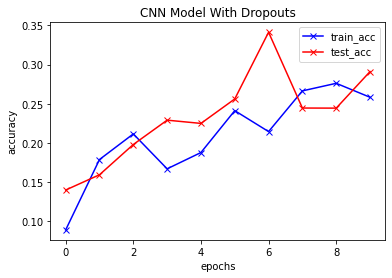

In [24]:
_# Plot accuracy for CNN model WITH dropouts
plot_accuracy(history, 'CNN Model With Dropouts', 'test')

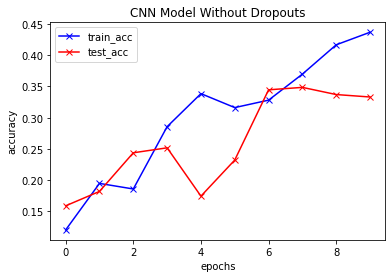

In [25]:
# Plot accuracy for CNN model WITHOUT dropouts
plot_accuracy(history2, 'CNN Model Without Dropouts', 'test')

### Task III: ResNet Training on the DBI

##### ResNet-18 Model

In [26]:
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [27]:
resnet18model = DogBreedResnet18()
resnet18model2 = DogBreedResnet18()
to_device(resnet18model, device)
to_device(resnet18model2, device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DogBreedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [28]:
evaluate(resnet18model, val_dl)   

{'val_loss': 3.478070020675659, 'val_acc': 0.0}

###### III.a: ResNet-18 on DBI

In [29]:
hist_val = fit_one_cycle(num_epochs, max_lr, resnet18model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.3107, val_loss: 3.1766, train_acc: 0.1332, val_acc: 0.1333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 2.1518, val_loss: 2.0347, train_acc: 0.1339, val_acc: 0.0667


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.8436, val_loss: 2.1103, train_acc: 0.2686, val_acc: 0.0222


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.7910, val_loss: 2.0672, train_acc: 0.2812, val_acc: 0.0667


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.6502, val_loss: 1.8443, train_acc: 0.3207, val_acc: 0.3556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.6150, val_loss: 1.6202, train_acc: 0.3467, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.4742, val_loss: 2.4481, train_acc: 0.4144, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.4078, val_loss: 1.8571, train_acc: 0.4725, val_acc: 0.3111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.3470, val_loss: 1.5165, train_acc: 0.4821, val_acc: 0.3778


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.3218, val_loss: 1.5103, train_acc: 0.4978, val_acc: 0.4222


In [30]:
hist_test = fit_one_cycle(num_epochs, max_lr, resnet18model2, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.2114, val_loss: 3.0278, train_acc: 0.0670, val_acc: 0.1317


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 2.1046, val_loss: 1.9798, train_acc: 0.1972, val_acc: 0.1630


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.8669, val_loss: 2.0078, train_acc: 0.2195, val_acc: 0.1975


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.7244, val_loss: 2.0110, train_acc: 0.3058, val_acc: 0.1940


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.6677, val_loss: 2.3813, train_acc: 0.3311, val_acc: 0.2290


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.5492, val_loss: 2.7514, train_acc: 0.3609, val_acc: 0.2289


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.4322, val_loss: 2.1564, train_acc: 0.4583, val_acc: 0.2637


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.4793, val_loss: 1.9059, train_acc: 0.3996, val_acc: 0.2672


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.3483, val_loss: 1.8538, train_acc: 0.4799, val_acc: 0.3258


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.3189, val_loss: 1.7478, train_acc: 0.4940, val_acc: 0.3453


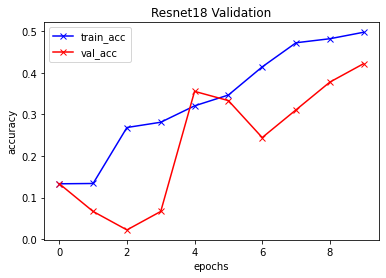

In [32]:
plot_accuracy(hist_val, 'Resnet18 Validation', 'val')

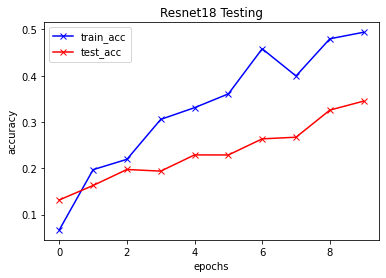

In [33]:
plot_accuracy(hist_test, 'Resnet18 Testing', 'test')

###### III.b: ResNet-18 on SDD

Load SDD dataset

In [34]:
# load DBI dataset to PyTorch Dataset Format.

sdd_dataset = ImageFolder('/content/drive/MyDrive/CSC420/datasets/SDD_subset')
print(f'{len(dataset)} images')

# set up datasets
sdd_test_dataset = DogBreedDataset(sdd_dataset, image_transforms['test'])

# Create DataLoaders
batch_size = 64

sdd_test_dl = DataLoader(sdd_test_dataset, batch_size*2, num_workers=2, pin_memory=True)
# moving sdd test dataloader to gpu
sdd_test_dl = DeviceDataLoader(sdd_test_dl, device)



646 images


In [35]:
resnet18modelSDD = DogBreedResnet18()
to_device(resnet18modelSDD, device)

DogBreedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [36]:
hist_sdd = fit_one_cycle(num_epochs, max_lr, resnet18modelSDD, train_dl, sdd_test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.3231, val_loss: 3.0956, train_acc: 0.0707, val_acc: 0.1164


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 2.2213, val_loss: 1.9954, train_acc: 0.1726, val_acc: 0.1875


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.9064, val_loss: 2.1098, train_acc: 0.2173, val_acc: 0.1406


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.7589, val_loss: 2.1773, train_acc: 0.3036, val_acc: 0.1582


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.6404, val_loss: 2.1881, train_acc: 0.3393, val_acc: 0.2285


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.5728, val_loss: 2.2574, train_acc: 0.3832, val_acc: 0.2316


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.5018, val_loss: 2.1176, train_acc: 0.4107, val_acc: 0.2623


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.4517, val_loss: 2.7350, train_acc: 0.4122, val_acc: 0.2549


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.3593, val_loss: 2.1219, train_acc: 0.4777, val_acc: 0.2454


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.3350, val_loss: 1.9726, train_acc: 0.4911, val_acc: 0.2788


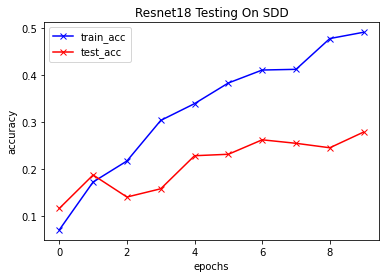

In [37]:
plot_accuracy(hist_sdd, 'Resnet18 Testing On SDD', 'test')

### Task IV: Fine-tuning on the DBI

##### Pretrained Resnet Models

Use three pretrained models from PyTorch: ResNet18,
ResNet34, and ResNeXt32.

In [38]:
class DogBreedPretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [39]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [40]:
class DogBreedPretrainedResnext32(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

##### Pretrained Model Accuracy on DBI

In [41]:
pretrained_resnet18_model = DogBreedPretrainedResnet18()
pretrained_resnet34_model = DogBreedPretrainedResnet34()
pretrained_resnext32_model = DogBreedPretrainedResnext32()

to_device(pretrained_resnet18_model, device)
to_device(pretrained_resnet34_model, device)
to_device(pretrained_resnext32_model, device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

DogBreedPretrainedResnext32(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [42]:
hist_pretrained_resnet18 = fit_one_cycle(num_epochs, max_lr, pretrained_resnet18_model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.5615, val_loss: 2.3872, train_acc: 0.0551, val_acc: 0.3174


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.3674, val_loss: 0.5538, train_acc: 0.6682, val_acc: 0.8838


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.3064, val_loss: 0.2315, train_acc: 0.9323, val_acc: 0.9109


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.1413, val_loss: 0.1497, train_acc: 0.9695, val_acc: 0.9420


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.0695, val_loss: 0.1572, train_acc: 0.9784, val_acc: 0.9341


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.0475, val_loss: 0.1728, train_acc: 0.9859, val_acc: 0.9264


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.0346, val_loss: 0.1163, train_acc: 0.9955, val_acc: 0.9572


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.0377, val_loss: 0.1039, train_acc: 0.9955, val_acc: 0.9728


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0290, val_loss: 0.1067, train_acc: 0.9940, val_acc: 0.9651


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0285, val_loss: 0.0986, train_acc: 0.9933, val_acc: 0.9728


In [43]:
hist_pretrained_resnet34 = fit_one_cycle(num_epochs, max_lr, pretrained_resnet34_model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.6097, val_loss: 2.3653, train_acc: 0.0632, val_acc: 0.3139


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.2361, val_loss: 0.3029, train_acc: 0.6659, val_acc: 0.9149


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.2342, val_loss: 0.2393, train_acc: 0.9382, val_acc: 0.9148


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.0483, val_loss: 0.2282, train_acc: 0.9911, val_acc: 0.9304


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.0366, val_loss: 0.1571, train_acc: 0.9911, val_acc: 0.9459


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.0193, val_loss: 0.1091, train_acc: 0.9978, val_acc: 0.9613


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.0330, val_loss: 0.1027, train_acc: 0.9874, val_acc: 0.9613


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.0078, val_loss: 0.1189, train_acc: 1.0000, val_acc: 0.9498


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0108, val_loss: 0.1156, train_acc: 1.0000, val_acc: 0.9498


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0115, val_loss: 0.1062, train_acc: 0.9978, val_acc: 0.9575


In [44]:
hist_pretrained_resnext32 = fit_one_cycle(num_epochs, max_lr, pretrained_resnext32_model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.0897, val_loss: 1.9375, train_acc: 0.1518, val_acc: 0.6169


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.9793, val_loss: 0.1445, train_acc: 0.8705, val_acc: 0.9691


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.1028, val_loss: 0.1729, train_acc: 0.9799, val_acc: 0.9341


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.0524, val_loss: 0.0521, train_acc: 0.9896, val_acc: 0.9768


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.0368, val_loss: 0.1385, train_acc: 0.9844, val_acc: 0.9535


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.0163, val_loss: 0.1183, train_acc: 0.9955, val_acc: 0.9651


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.0111, val_loss: 0.0741, train_acc: 0.9978, val_acc: 0.9691


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.0179, val_loss: 0.0428, train_acc: 0.9940, val_acc: 0.9845


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0242, val_loss: 0.0271, train_acc: 0.9918, val_acc: 0.9961


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0138, val_loss: 0.0269, train_acc: 0.9911, val_acc: 0.9961


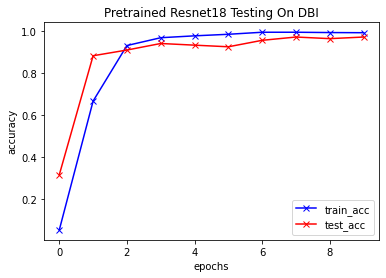

In [45]:
plot_accuracy(hist_pretrained_resnet18, 'Pretrained Resnet18 Testing On DBI', 'test')

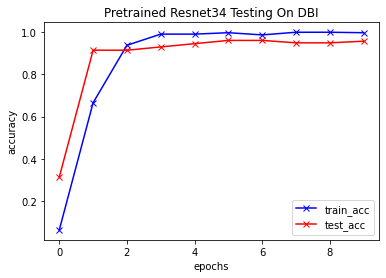

In [46]:
plot_accuracy(hist_pretrained_resnet34, 'Pretrained Resnet34 Testing On DBI', 'test')

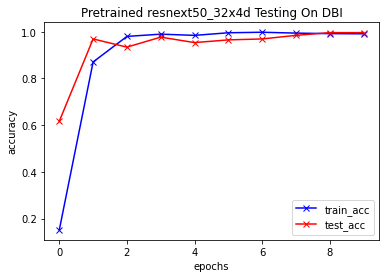

In [55]:
plot_accuracy(hist_pretrained_resnext32, 'Pretrained resnext50_32x4d Testing On DBI', 'test')

##### Pretrained Model Accuracy on SDD

In [48]:
pretrained_resnet18_model_sdd = DogBreedPretrainedResnet18()
pretrained_resnet34_model_sdd = DogBreedPretrainedResnet34()
pretrained_resnext32_model_sdd = DogBreedPretrainedResnext32()

to_device(pretrained_resnet18_model_sdd, device)
to_device(pretrained_resnet34_model_sdd, device)
to_device(pretrained_resnext32_model_sdd, device)

DogBreedPretrainedResnext32(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [49]:
hist_pretrained_resnet18_sdd = fit_one_cycle(num_epochs, max_lr, pretrained_resnet18_model_sdd, train_dl, sdd_test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.9359, val_loss: 2.8100, train_acc: 0.0223, val_acc: 0.1606


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.4819, val_loss: 1.0105, train_acc: 0.5990, val_acc: 0.6218


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.3026, val_loss: 0.4810, train_acc: 0.9301, val_acc: 0.8269


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.1497, val_loss: 0.4367, train_acc: 0.9472, val_acc: 0.8412


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.1058, val_loss: 0.4880, train_acc: 0.9628, val_acc: 0.8394


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.0402, val_loss: 0.4428, train_acc: 0.9955, val_acc: 0.8473


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.0530, val_loss: 0.4255, train_acc: 0.9851, val_acc: 0.8440


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.0381, val_loss: 0.3983, train_acc: 0.9896, val_acc: 0.8523


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0196, val_loss: 0.3657, train_acc: 1.0000, val_acc: 0.8632


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0230, val_loss: 0.3661, train_acc: 0.9978, val_acc: 0.8640


In [50]:
hist_pretrained_resnet34_sdd = fit_one_cycle(num_epochs, max_lr, pretrained_resnet34_model_sdd, train_dl, sdd_test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.3389, val_loss: 2.2370, train_acc: 0.0543, val_acc: 0.3626


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.1556, val_loss: 0.6396, train_acc: 0.7336, val_acc: 0.7979


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.1798, val_loss: 0.5687, train_acc: 0.9435, val_acc: 0.7952


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.0756, val_loss: 0.4419, train_acc: 0.9777, val_acc: 0.8455


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.0452, val_loss: 0.3781, train_acc: 0.9874, val_acc: 0.8669


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.0246, val_loss: 0.2932, train_acc: 0.9955, val_acc: 0.8937


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.0158, val_loss: 0.2564, train_acc: 1.0000, val_acc: 0.9041


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.0212, val_loss: 0.2487, train_acc: 0.9940, val_acc: 0.9139


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0131, val_loss: 0.2536, train_acc: 0.9978, val_acc: 0.9117


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0222, val_loss: 0.2641, train_acc: 0.9881, val_acc: 0.9048


In [51]:
hist_pretrained_resnext32_sdd = fit_one_cycle(num_epochs, max_lr, pretrained_resnext32_model_sdd, train_dl, sdd_test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.1094, val_loss: 1.9696, train_acc: 0.1726, val_acc: 0.5185


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.0252, val_loss: 0.2999, train_acc: 0.8638, val_acc: 0.9201


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.1464, val_loss: 0.4761, train_acc: 0.9546, val_acc: 0.8619


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.0454, val_loss: 0.3276, train_acc: 0.9747, val_acc: 0.8940


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.0429, val_loss: 0.2288, train_acc: 0.9866, val_acc: 0.9257


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.0407, val_loss: 0.1681, train_acc: 0.9777, val_acc: 0.9464


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.0095, val_loss: 0.1320, train_acc: 1.0000, val_acc: 0.9588


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.0474, val_loss: 0.1350, train_acc: 0.9836, val_acc: 0.9583


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0087, val_loss: 0.1318, train_acc: 1.0000, val_acc: 0.9544


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0077, val_loss: 0.1335, train_acc: 0.9978, val_acc: 0.9568


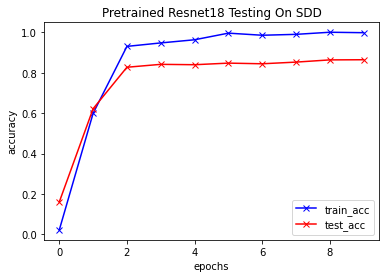

In [52]:
plot_accuracy(hist_pretrained_resnet18_sdd, 'Pretrained Resnet18 Testing On SDD', 'test')

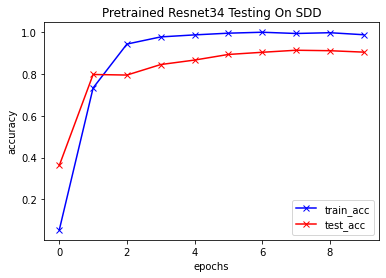

In [53]:
plot_accuracy(hist_pretrained_resnet34_sdd, 'Pretrained Resnet34 Testing On SDD', 'test')

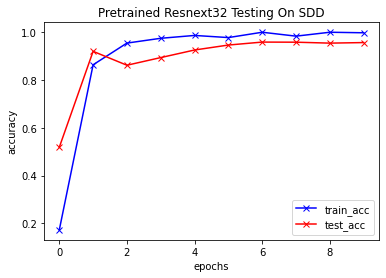

In [54]:
plot_accuracy(hist_pretrained_resnext32_sdd, 'Pretrained resnext50_32x4d Testing On SDD', 'test')

### Task V: Dataset Classification

##### Load new dataset

In [65]:
# load new reorganized dataset
# all dog images are classified to their dataset names 
# new labels are: 'DBI_subest' or 'SDD_subset'
dataset = ImageFolder('/content/drive/MyDrive/CSC420/task5_datasets')
print(f'{len(dataset)} images')

folders = []
for n in dataset.classes:
    folders.append(n)
print(folders)

1879 images
['DBI_subest', 'SDD_subset']


In [66]:
random_seed = 42
torch.manual_seed(random_seed)

In [72]:
# divide dataset into train and test
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

# set up datasets
train_ds = DogBreedDataset(train_ds, image_transforms['train'])
test_ds = DogBreedDataset(test_ds, image_transforms['test'])

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

# moving train & test dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

##### Train and plot

Start from pretrained Resnext50_32x4d model:

In [82]:
pretrained_resnext32_model_new = DogBreedPretrainedResnext32()
to_device(pretrained_resnext32_model_new, device)

DogBreedPretrainedResnext32(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [83]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

Fine-tune:

In [84]:
hist_pretrained_resnext32_new = fit_one_cycle(num_epochs, max_lr, pretrained_resnext32_model_new, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.6943, val_loss: 0.6401, train_acc: 0.5241, val_acc: 0.6383


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.3619, val_loss: 0.4443, train_acc: 0.8399, val_acc: 0.8176


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.2294, val_loss: 0.5195, train_acc: 0.8989, val_acc: 0.8081


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.1937, val_loss: 0.5638, train_acc: 0.9225, val_acc: 0.8111


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.1118, val_loss: 0.5199, train_acc: 0.9546, val_acc: 0.8346


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.0647, val_loss: 0.4538, train_acc: 0.9771, val_acc: 0.8489


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.0418, val_loss: 0.4491, train_acc: 0.9868, val_acc: 0.8385


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.0244, val_loss: 0.4226, train_acc: 0.9926, val_acc: 0.8550


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0172, val_loss: 0.4118, train_acc: 0.9957, val_acc: 0.8637


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0097, val_loss: 0.4125, train_acc: 0.9985, val_acc: 0.8580


Plot accuracy

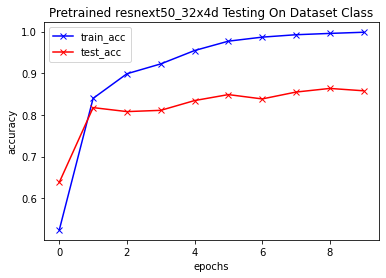

In [85]:
plot_accuracy(hist_pretrained_resnext32_new, 'Pretrained resnext50_32x4d Testing On Dataset Class', 'test')